In [155]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.yahoo_downloader import YahooDownloader
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
from utils.mean_variance_optimization import mvo_data

# mpl.rcParams['figure.dpi'] = 300
import math
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./dataset/dax_complete.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [156]:
df = df_dow.copy()

df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'UNH','MCD','CAT','CRM','V','AMGN','TRV','MSFT'])]
# df = df[df.tic.isin(['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BMW.DE', 'CON.DE', 'DBK.DE', 'DTE.DE', 'EOAN.DE', 'FME.DE', 'VOW3.DE'])]

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-12-30'

VALIDATION_START_DATE = '2021-01-01'
VALIDATION_END_DATE = '2021-12-30'

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-12-30'

INDICATORS = [
    "macd",
    "rsi_30",
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_prcies = fe.preprocess_data(df.query('date>"2000-01-01"'))
cleaned_data = processed_prcies.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
stock_dimension = len(cleaned_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added user defined features
Successfully added technical indicators
Stock Dimension: 10


In [159]:
# Compute exponentially weighted std of log returns
for window in [21, 42, 63]:
    cleaned_data[f'std_return_{window}'] = cleaned_data.groupby('tic')['logreturn'] \
        .transform(lambda x: x.ewm(span=window, min_periods=1,adjust=False).std() )
# Compute exponentially weighted std of closing prices for MACD normalization
cleaned_data['ewma_std_price_63'] = cleaned_data.groupby('tic')['close'] \
    .transform(lambda x: x.ewm(span=63, min_periods=1,adjust=False).std())

# Normalize MACD by price volatility
cleaned_data['macd_normal'] = cleaned_data['macd'] / cleaned_data['ewma_std_price_63']

# Rolling cumulative log returns over different periods
for window in [21, 42, 63]:
    cleaned_data[f'return_sum_{window}'] = cleaned_data.groupby('tic')['logreturn'] \
        .transform(lambda x: x.ewm(span=window, min_periods=1,adjust=False).mean())

# Normalize rolling log returns by their respective volatilities
for window in [21, 42, 63]:
    cleaned_data[f'r_{window}'] = cleaned_data[f'return_sum_{window}'] / cleaned_data[f'std_return_{window}']
cleaned_data['rsi_30'] = cleaned_data['rsi_30']/100

In [166]:
pv_simple_return = cleaned_data.pivot_table(index='date',values='return',columns='tic')
pv_simple_log_return = cleaned_data.pivot_table(index='date',values='logreturn',columns='tic')
pv_simple_rsi = cleaned_data.pivot_table(index='date',values='rsi_30',columns='tic')
pv_simple_macd_normal= cleaned_data.pivot_table(index='date',values='macd',columns='tic')
pv_simple_std= cleaned_data.pivot_table(index='date',values='ewma_std_price_63',columns='tic')
pv_m_21= cleaned_data.pivot_table(index='date',values='return_sum_21',columns='tic')

<Axes: xlabel='date'>

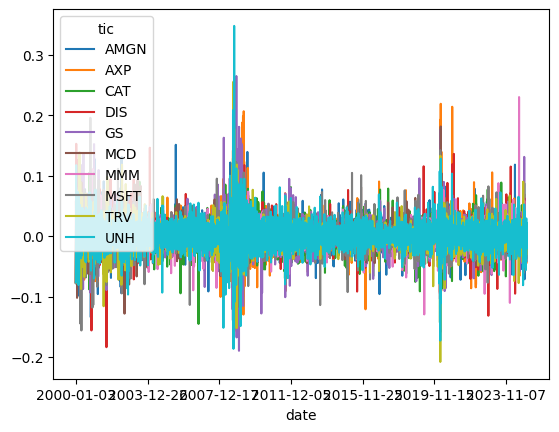

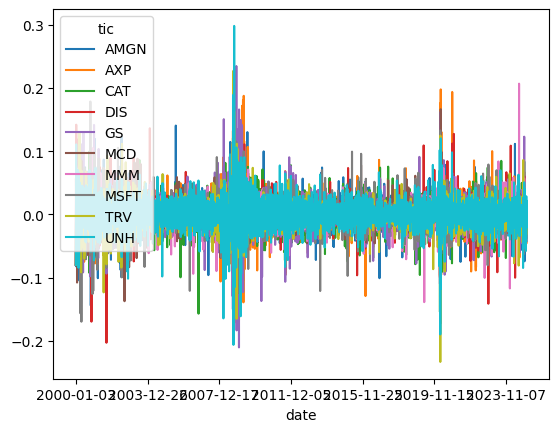

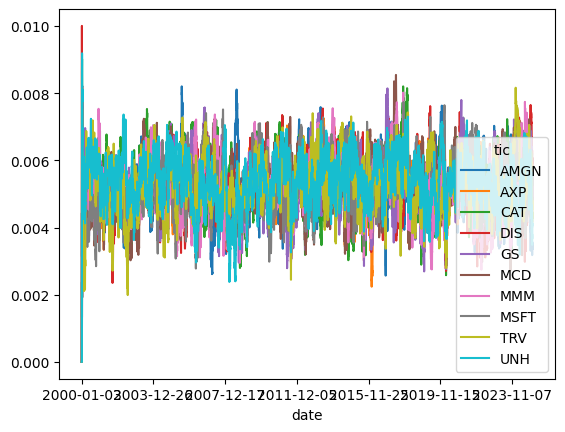

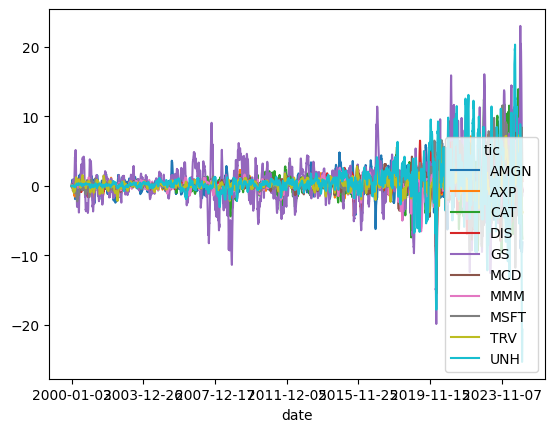

In [167]:
%matplotlib inline

pv_simple_return.plot()
pv_simple_log_return.plot()
pv_simple_rsi.plot()
pv_simple_macd_normal.plot()


In [160]:
covs = mvo.mvo_data(cleaned_data,risk_model='sample_cov')

In [9]:
with open('./data/dax_normal_processed.pkl', 'wb') as file: 
    pickle.dump(cleaned_data, file) 

In [161]:
with open('./data/dow_processed.pkl', 'wb') as file: 
    pickle.dump(covs, file) 

In [50]:
with open('./data/dow_processed.pkl', 'rb') as file: 
    cleaned_data = pickle.load(file)

In [35]:
cleaned_data['macd']

0        -0.127483
1        -0.373269
2         0.623188
3        -0.713321
4         2.575090
           ...    
60355    -0.847394
60356    -0.291080
60357     1.384540
60358    -3.734955
60359   -20.696047
Name: macd, Length: 60360, dtype: float64

<Axes: >

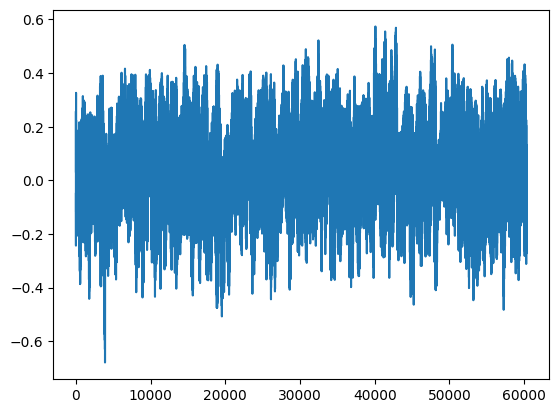

In [177]:
cleaned_data['r_42'].plot()

In [48]:
with open('./data/dow_normal_processed.pkl', 'rb') as file:
     cleaned_data= pickle.load(file)

In [ ]:

train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())


In [52]:
cleaned_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,return,...,return_sum_63,return_sum_252,r_21,r_42,r_63,r_252,time,cov_list,corr_list,returns
0,6805,2001-01-02,65.875000,66.500000,62.375000,44.216507,6449200,AMGN,1,-0.016618,...,-0.001327,-0.000458,-0.103543,-0.050444,-0.036055,-0.011800,2001-01-02,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN 0.155248 AXP 0.057496 CAT ...
1,6806,2001-01-02,47.703850,47.867970,45.132656,32.531967,4394265,AXP,1,-0.053470,...,-0.002008,-0.000505,-0.132113,-0.089459,-0.069884,-0.018101,2001-01-02,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN 0.155248 AXP 0.057496 CAT ...
2,6808,2001-01-02,23.625000,23.625000,22.812500,12.545938,3285000,CAT,1,-0.021136,...,0.005143,0.001560,0.268799,0.257504,0.213182,0.060258,2001-01-02,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN 0.155248 AXP 0.057496 CAT ...
3,6811,2001-01-02,28.053595,28.053595,27.252064,21.499493,6545261,DIS,1,-0.034557,...,-0.004025,-0.002070,-0.109085,-0.126732,-0.126546,-0.070105,2001-01-02,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN 0.155248 AXP 0.057496 CAT ...
4,6812,2001-01-02,104.375000,105.500000,97.500000,71.436340,3202400,GS,1,-0.062537,...,0.001646,0.000261,0.139409,0.083000,0.044525,0.007220,2001-01-02,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN 0.155248 AXP 0.057496 CAT ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60355,180611,2024-12-30,291.470001,291.470001,289.000000,289.600006,1936700,MCD,0,-0.013691,...,-0.000391,0.000257,-0.169406,-0.080463,-0.037766,0.023400,2024-12-30,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN -0.155497 AXP 0.480394 CAT ...
60356,180612,2024-12-30,129.119995,129.919998,127.919998,129.130005,2154000,MMM,0,-0.008066,...,-0.000003,0.001209,-0.043720,-0.023495,-0.000189,0.064740,2024-12-30,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN -0.155497 AXP 0.480394 CAT ...
60357,180614,2024-12-30,426.059998,427.549988,421.899994,424.829987,13158700,MSFT,0,-0.013240,...,-0.000333,0.000351,-0.194242,-0.060048,-0.025236,0.026431,2024-12-30,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN -0.155497 AXP 0.480394 CAT ...
60358,180617,2024-12-30,239.880005,241.169998,237.610001,239.869995,734300,TRV,0,-0.006379,...,-0.000742,0.000668,-0.207304,-0.109886,-0.050223,0.044617,2024-12-30,tic AMGN AXP CAT DIS ...,tic AMGN AXP CAT DIS ...,tic AMGN -0.155497 AXP 0.480394 CAT ...


In [16]:
pv_simple_return = train_data.pivot_table(index='date',values='return',columns='tic')
pv_simple_log_return = train_data.pivot_table(index='date',values='log_return',columns='tic')
pv_simple_rsi = train_data.pivot_table(index='date',values='rsi_30',columns='tic')
pv_simple_macd_normal= train_data.pivot_table(index='date',values='macd_normal',columns='tic')
pv_simple_std= train_data.pivot_table(index='date',values='ewma_std_price_63',columns='tic')
pv_m_21= train_data.pivot_table(index='date',values='return_sum_21',columns='tic')



In [ ]:
%matplotlib inline

pv_simple_return.plot()
pv_simple_log_return.plot()
pv_simple_rsi.plot()
pv_simple_macd_normal.plot()



# Proximal Policy Optimization

In [74]:

from models import MODELS


def load_from_file(model_name, environment, cwd, deterministic=True):
    if model_name not in MODELS:
        raise ValueError(
            f"Model '{model_name}' not found in MODELS."
        )  # this is more informative than NotImplementedError("NotImplementedError")
    try:
        # load agent
        model = MODELS[model_name].load(cwd)
        print("Successfully load model", cwd)
    except BaseException as error:
        raise ValueError(
            f"Failed to load agent. Error: {str(error)}") from error

    # test on the testing env
    state = environment.reset()[0]
    done = False
    tiks = environment._tic_list.tolist()
    while not done:
        state = state.reshape(1,-1)
        action = model.predict(state, deterministic=deterministic)[0]
        date_list = environment._date_memory
        portfolio_return = environment._portfolio_return_memory
        result_df = pd.DataFrame(
            {"date": date_list, "daily_return": portfolio_return,
                'account':  environment._asset_memory["final"], 'weights': environment._final_weights}
        )
        state, reward, done, _, _ = environment.step(action)
    return result_df, tiks


In [75]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                 ],
#                         model_name="td3",
#                         args={'gamma': 0.90, 'learning_rate': 1e-4,
#                             "buffer_size": 300_000, "batch_size": 124,
#                             "action_noise": "normal"},
#                         window_size=21,
#                         policy_kwargs=dict(
#                             activation_fn=activ_func,
#                         ),
#                         iterations=1000_000)

test_env = optimizer.create_environment(test_data,
                          features=["close", "logreturn",
                                    "macd_normal", "rsi_30","corr_list"],
                                        window=63)
ppo_test_result = load_from_file(
    'RecurrentPPO',test_env, 
    cwd="data/RecurrentPPO_close_logreturn_macd_normal_rsi_30_corr_list_window_size_63_0.002_rppo_dow_leaky_relu/RecurrentPPO_150000_steps"
    ,deterministic=True)

Successfully load model data/RecurrentPPO_close_logreturn_macd_normal_rsi_30_corr_list_window_size_63_0.002_rppo_dow_leaky_relu/RecurrentPPO_150000_steps
Initial portfolio value:250000
Final portfolio value: 349197.78125
Final accumulative portfolio value: 1.3967911005020142
Maximum DrawDown: -0.15195349769198108
Sharpe ratio: 0.883156911916955


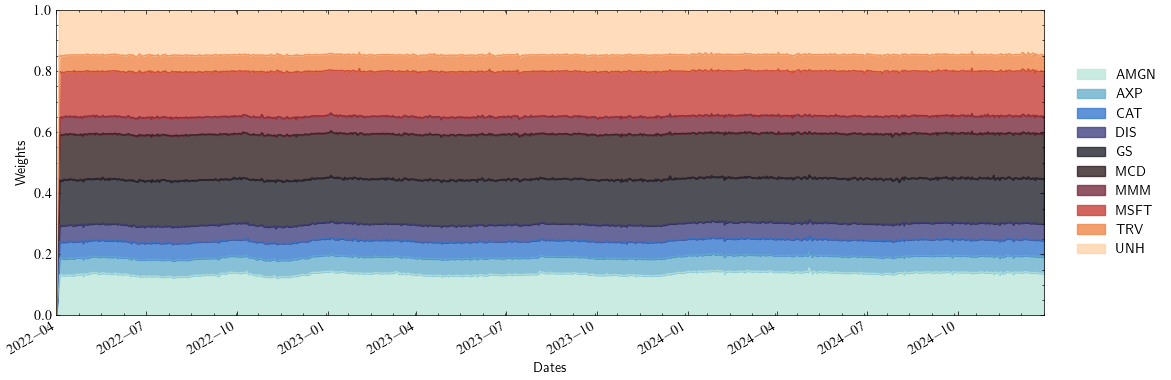

In [76]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

In [79]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=False,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                 ],
#                         model_name="td3",
#                         args={'gamma': 0.90, 'learning_rate': 1e-4,
#                             "buffer_size": 300_000, "batch_size": 124,
#                             "action_noise": "normal"},
#                         window_size=21,
#                         policy_kwargs=dict(
#                             activation_fn=activ_func,
#                         ),
#                         iterations=1000_000)

test_env = optimizer.create_environment(test_data,
                          features=["close", "logreturn",
                                    "macd_normal",
                                    ],
                                        window=63)
ppo_test_result = optimizer.load_from_file(
    'ppo',test_env, 
    cwd="data/ppo_close_logreturn_macd_normal_window_size_63_0.002_ppo_dow_leaky_relu/ppo_250000_steps"
    ,deterministic=True)

Successfully load model data/ppo_close_logreturn_macd_normal_window_size_63_0.002_ppo_dow_leaky_relu/ppo_250000_steps
Initial portfolio value:250000
Final portfolio value: 348173.0625
Final accumulative portfolio value: 1.3926922082901
Maximum DrawDown: -0.18148842545063182
Sharpe ratio: 0.8212533954247198


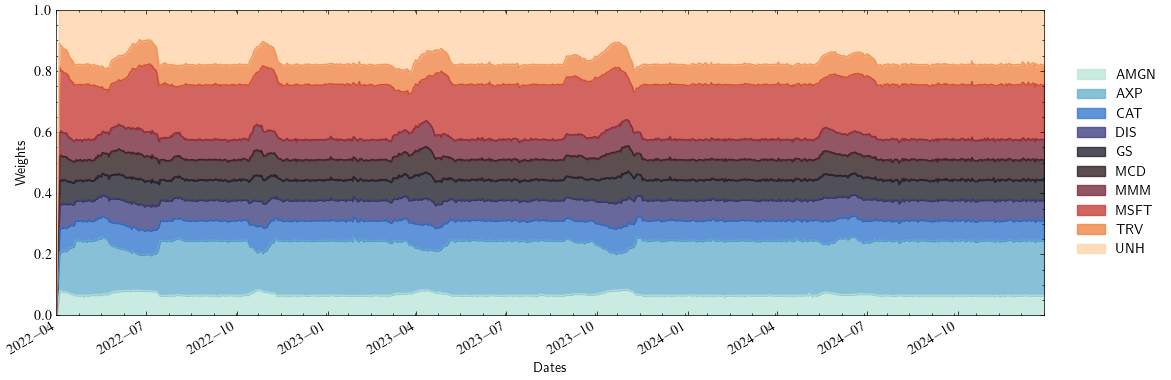

In [80]:
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False)

## TD3

In [157]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                 ],
#                         model_name="td3",
#                         args={'gamma': 0.90, 'learning_rate': 1e-4,
#                             "buffer_size": 300_000, "batch_size": 124,
#                             "action_noise": "normal"},
#                         window_size=21,
#                         policy_kwargs=dict(
#                             activation_fn=activ_func,
#                         ),
#                         iterations=1000_000)

test_env = optimizer.create_environment(test_data,
                          features=["close", "log_return", "r_21", "r_42", "r_63",
                                    "macd", "rsi_30", 'corr_list'
                                    ],
                                        window=21)
td3_test_result = load_from_file(
    'td3',test_env, 
    cwd="data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_21_0.001_td3_leaky_relu/td3_110000_steps"
    ,deterministic=True)

Successfully load model data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_21_0.001_td3_leaky_relu/td3_110000_steps
Initial portfolio value:250000
Final portfolio value: 372643.9375
Final accumulative portfolio value: 1.4905757904052734
Maximum DrawDown: -0.18088865225689887
Sharpe ratio: 0.9185454269578941


In [150]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=False, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                       validation_data,
#                       features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30","corr_list"
#                                 ],
#                       model_name="ppo",
#                       args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
#                             'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
#                       window_size=5,
#                       iterations=1000_000)

test_env = optimizer.create_environment(test_data,features=[
                                "close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30",'corr_list'
                                  ],window=42)
td3_test_result = load_from_file(
    'td3',test_env, 
    cwd="data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_td3_leaky_relu/td3_310000_steps"
    ,deterministic=True)

Successfully load model data/td3_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_td3_leaky_relu/td3_310000_steps
Initial portfolio value:250000
Final portfolio value: 351331.9375
Final accumulative portfolio value: 1.4053277969360352
Maximum DrawDown: -0.18040545767680094
Sharpe ratio: 0.8222973573974212


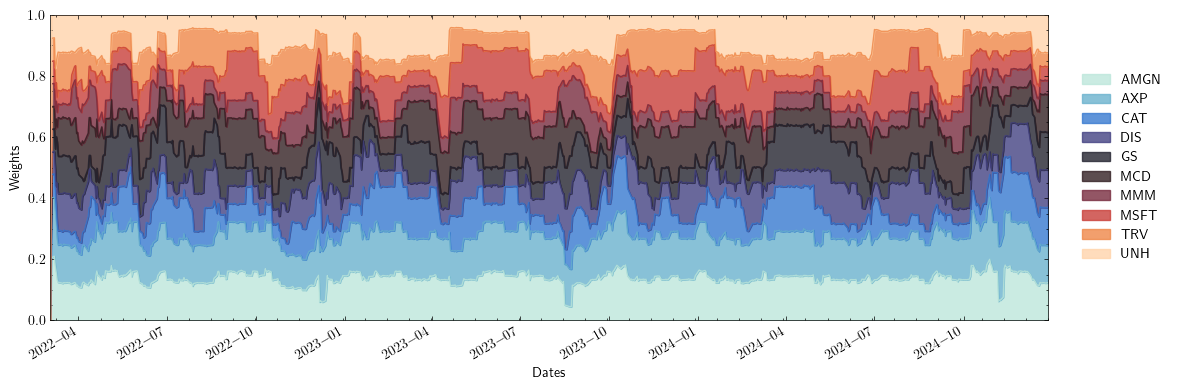

In [151]:
from utils.plotting_helpers import plot_weights
plot_weights(td3_test_result[0].weights, td3_test_result[0].date, td3_test_result[1],add_cash=False,name='td3')

## Mean Variance Optimization

In [6]:
covariances = mvo.mvo_data(cleaned_data,'mean_historical_return')

In [159]:
TEST_START_DATE

'2022-01-01'

Initial portfolio value:1000000
Final portfolio value: 1270391.5
Final accumulative portfolio value: 1.2703914642333984
Maximum DrawDown: -0.1363493243974857
Sharpe ratio: 0.673829006472675


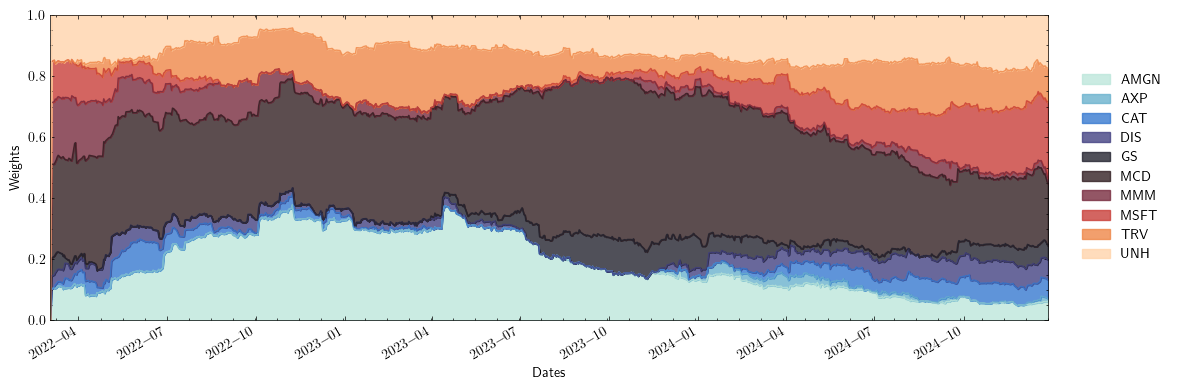

In [144]:
test_covariances = data_split(cleaned_data,TEST_START_DATE,TEST_END_DATE)
min_variacen_portfolio = mvo.mean_variance_optimization(test_covariances,commission_fee=0,window=42)
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False,name='mvo_dow')

Initial portfolio value:1000000
Final portfolio value: 1101299.75
Final accumulative portfolio value: 1.10129976272583
Maximum DrawDown: -0.35420269676645977
Sharpe ratio: 0.2757678928086221


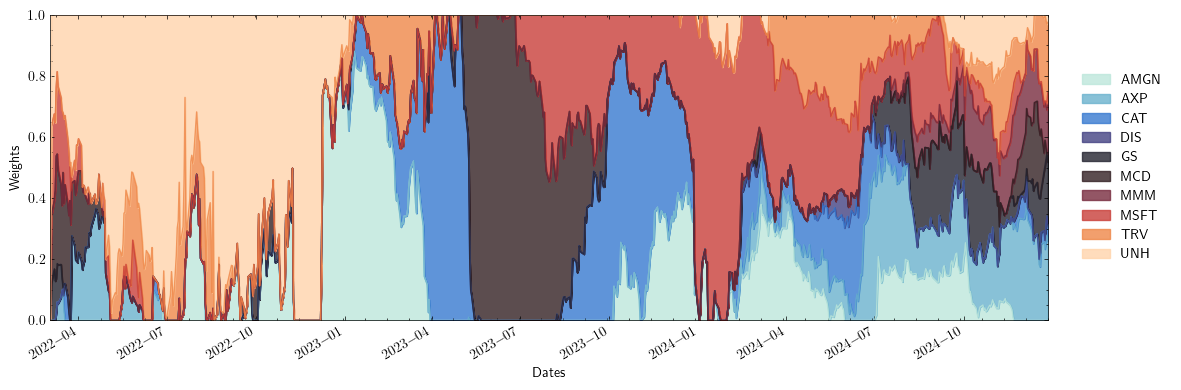

In [145]:
result_sharpe = mvo.mean_variance_optimization(test_covariances,commission_fee=0,objective='sharpe',window=42,risk_free_rate=0.04)
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False,name='mvo_sharpe')

Initial portfolio value:1000000
Final portfolio value: 1113015.875
Final accumulative portfolio value: 1.11301589012146
Maximum DrawDown: -0.23064975
Sharpe ratio: 0.44302152632623965


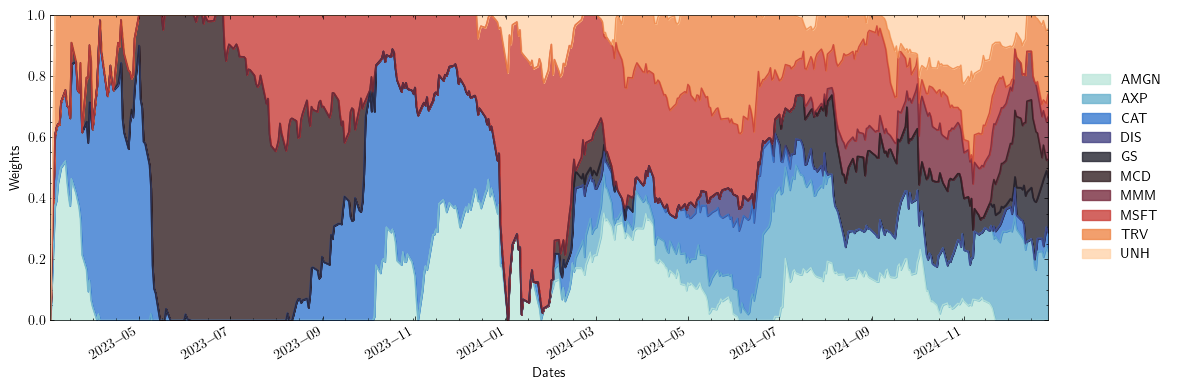

In [34]:
result_sharpe = mvo.mean_variance_optimization(test_covariances,commission_fee=0,objective='sharpe',window=42)
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False,name='mvo_sharpe')

## Buy and Hold

In [147]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=21,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1413915.375
Final accumulative portfolio value: 1.4139153957366943
Maximum DrawDown: -0.17891285143582725
Sharpe ratio: 0.8177548784017118


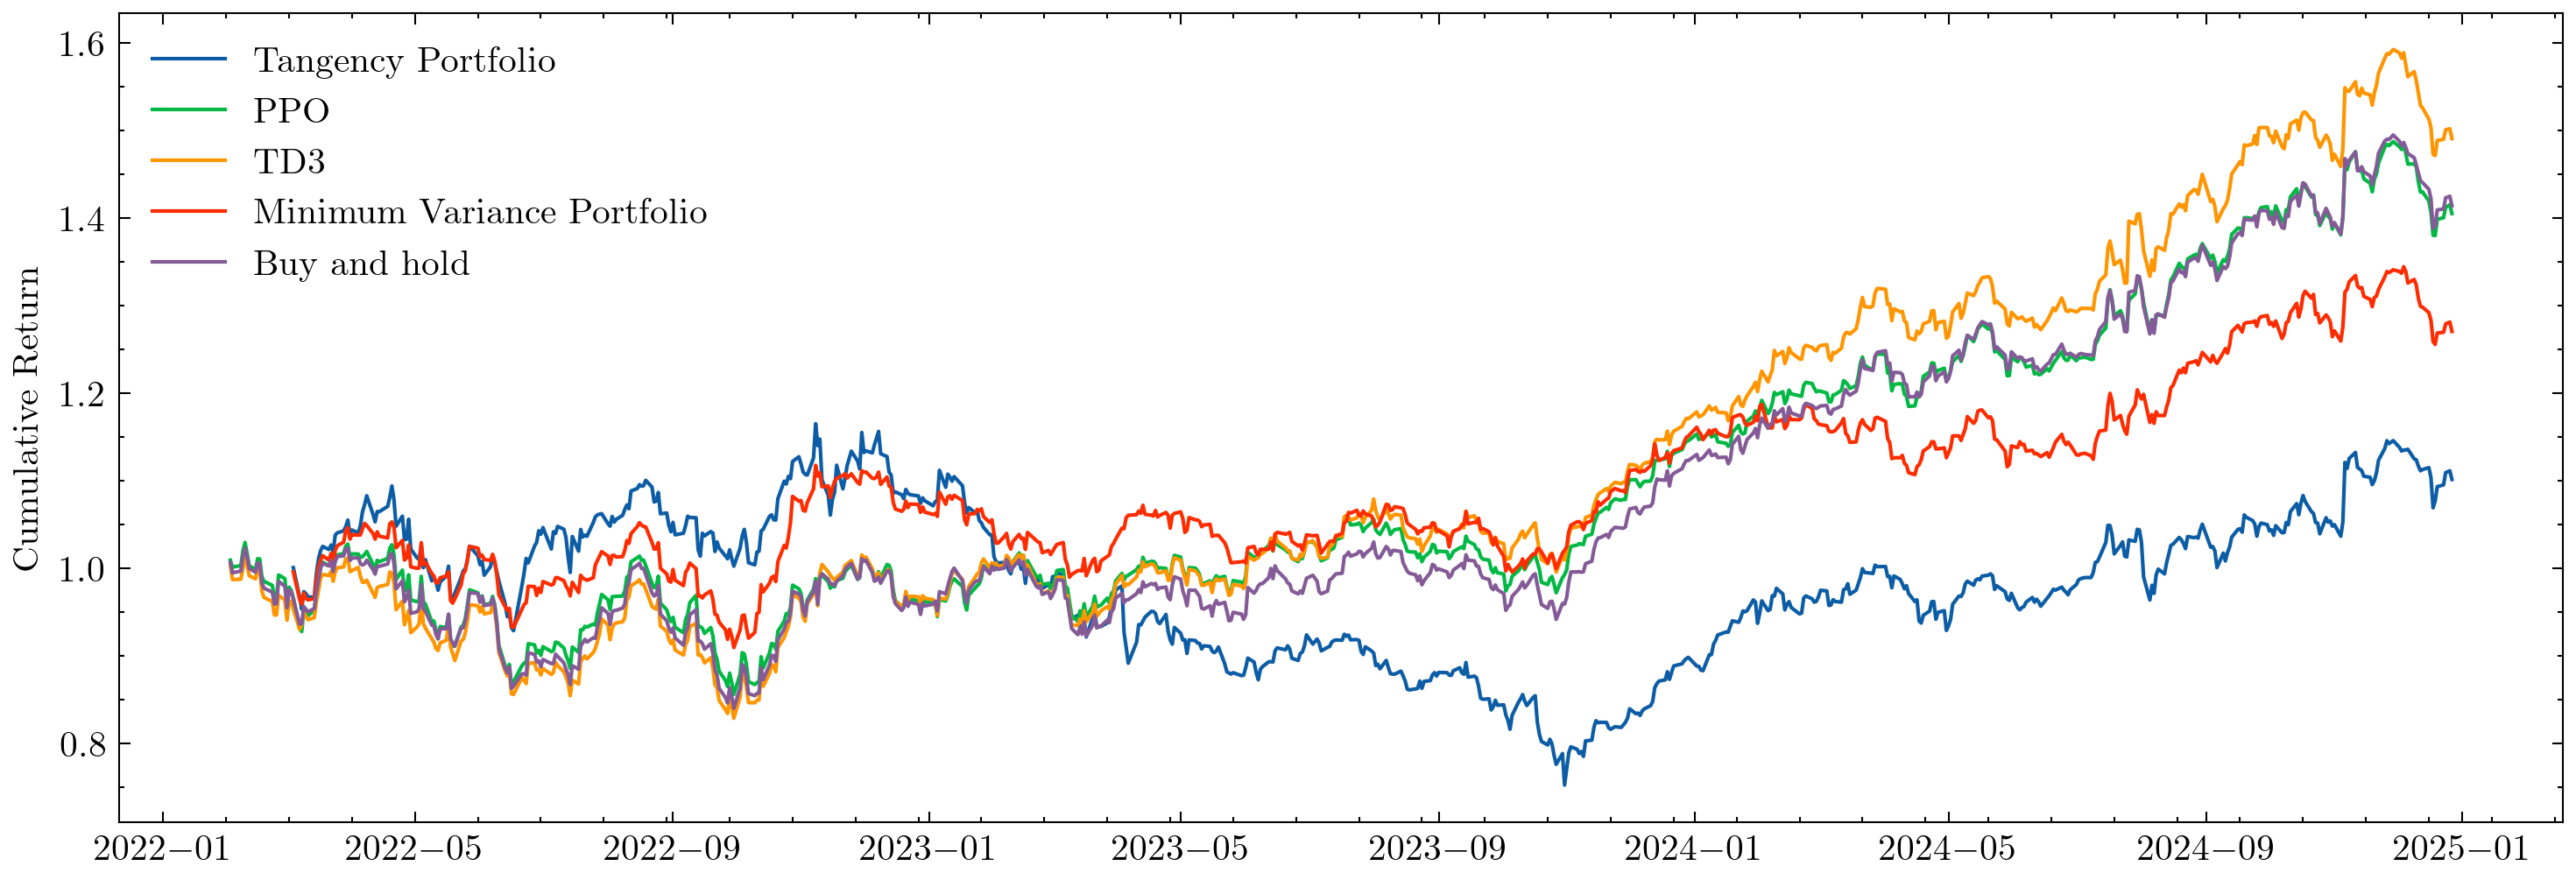

In [159]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe[0].get('date'),(result_sharpe[0]['account'].pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(td3_test_result[0].get('date'),(td3_test_result[0]['account'].pct_change() +1).cumprod(),label='TD3')
    plt.plot(min_variacen_portfolio[0].get('date'),(min_variacen_portfolio[0]['account'].pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [161]:
import quantstats as qs

In [162]:
ppo_returns = ppo_test_result[0][['date','account']]

ppo_stats={}
ppo_returns.set_index('date',inplace=True)
ppo_stats['name']  = 'Proximal Policy Optimization'
ppo_stats['sharpe_ratio'] = qs.stats.sharpe(ppo_returns)['account']
ppo_stats['max_drow_down'] = qs.stats.max_drawdown(ppo_returns)['account']
ppo_stats['var'] = qs.stats.var(ppo_returns)[0].item()
ppo_stats['return'] = qs.stats.comp(ppo_returns['account'].pct_change())
ppo_stats

{'name': 'Proximal Policy Optimization',
 'sharpe_ratio': np.float64(0.818864365180634),
 'max_drow_down': np.float64(-0.16863606278653187),
 'var': -0.015907710759364677,
 'return': np.float64(0.4049706250000005)}

In [163]:
td3_returns = td3_test_result[0][['date','account']]

td3_stats={}
td3_returns.set_index('date',inplace=True)
td3_stats['name']  = 'TD3'
td3_stats['sharpe_ratio'] = qs.stats.sharpe(td3_returns)['account']
td3_stats['max_drow_down'] = qs.stats.max_drawdown(td3_returns)['account']
td3_stats['var'] = qs.stats.var(td3_returns)[0].item()
td3_stats['return'] = qs.stats.comp(td3_returns['account'].pct_change())
td3_stats

{'name': 'TD3',
 'sharpe_ratio': np.float64(0.9185437299811848),
 'max_drow_down': np.float64(-0.18088865225689887),
 'var': -0.01644898886876325,
 'return': np.float64(0.49057575000000386)}

In [164]:
mvo_min_returns = min_variacen_portfolio[0][['date','account']]
mvo_min_returns.set_index('date',inplace=True)

mvo_min_stats={}
mvo_min_stats['name']  = 'Min variance portfolio'
mvo_min_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_min_returns)['account']
mvo_min_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_min_returns)['account']
mvo_min_stats['var']  = qs.stats.var(mvo_min_returns)[0].item()
mvo_min_stats['return'] = qs.stats.comp(mvo_min_returns['account'].pct_change())
mvo_min_stats

{'name': 'Min variance portfolio',
 'sharpe_ratio': np.float64(0.6738300671387691),
 'max_drow_down': np.float64(-0.1363493243974857),
 'var': -0.014209119453322,
 'return': np.float64(0.27039149999999723)}

In [165]:

mvo_sharpe_returns = result_sharpe[0][['date','account']]
mvo_sharpe_returns.set_index('date',inplace=True)
mvo_sharpe_stats={}
mvo_sharpe_stats['name']  = 'Tangency Portfolio'
mvo_sharpe_stats['sharpe_ratio'] = qs.stats.sharpe(mvo_sharpe_returns)['account']
mvo_sharpe_stats['max_drow_down']  = qs.stats.max_drawdown(mvo_sharpe_returns)['account']
mvo_sharpe_stats['var']  = qs.stats.var(mvo_sharpe_returns)[0].item()
mvo_sharpe_stats['return'] = qs.stats.comp(mvo_sharpe_returns['account'].pct_change())
mvo_sharpe_stats

{'name': 'Tangency Portfolio',
 'sharpe_ratio': np.float64(0.2757672473578014),
 'max_drow_down': np.float64(-0.35420269676645977),
 'var': -0.01934827285704158,
 'return': np.float64(0.10129974999999969)}

In [166]:
bh_df = pd.DataFrame()
bh_df['asset']=environment_train_buy_and_hold_sp500._portfolio_return_memory
bh_df['date']=environment_train_buy_and_hold_sp500._date_memory
bh_df.set_index('date',inplace=True)
bh_stats={}
bh_stats['name']  = 'Buy and Hold'
bh_stats['sharpe_ratio'] = qs.stats.sharpe(bh_df)['asset']
bh_stats['max_drow_down'] = qs.stats.max_drawdown(bh_df)['asset']
bh_stats['var'] = qs.stats.var(bh_df)[0].item()
bh_stats['return'] = qs.stats.comp(bh_df['asset'])

bh_stats

{'name': 'Buy and Hold',
 'sharpe_ratio': np.float64(0.8177548784017118),
 'max_drow_down': np.float64(-0.17891266110010795),
 'var': -0.016267600169839826,
 'return': np.float64(0.4139171709135816)}

In [167]:
stats = [bh_stats,mvo_sharpe_stats,mvo_min_stats,ppo_stats,td3_stats]

In [168]:
stats_df = pd.DataFrame(stats)

In [169]:
stats_df

,name,sharpe_ratio,max_drow_down,var,return
0,Buy and Hold,0.817755,-0.178913,-0.016268,0.413917
1,Tangency Portfolio,0.275767,-0.354203,-0.019348,0.101300
2,Min variance portfolio,0.673830,-0.136349,-0.014209,0.270391
3,Proximal Policy Optimization,0.818864,-0.168636,-0.015908,0.404971
4,TD3,0.918544,-0.180889,-0.016449,0.490576


In [ ]:
with open('mytable.tex', 'w') as tf:
     tf.write(stats_df.to_latex())

## DAX

In [174]:
df_dax = read_csv('./dataset/dax_complete.csv')


In [177]:
covariances = mvo.mvo_data(cleaned_data,'mean_historical_return')

In [43]:
with open('./data/dax_normal_processed.pkl', 'rb') as file:
     cleaned_data= pickle.load(file)
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-12-30'

VALIDATION_START_DATE = '2021-01-01'
VALIDATION_END_DATE = '2021-12-30'

TEST_START_DATE = '2022-01-01'
TEST_END_DATE = '2024-12-30'
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())


# Sharpe and min-variance

## Buy and Hold

In [26]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=42,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1339127.25
Final accumulative portfolio value: 1.3391273021697998
Maximum DrawDown: -0.20539055891547164
Sharpe ratio: 0.7098220363851927


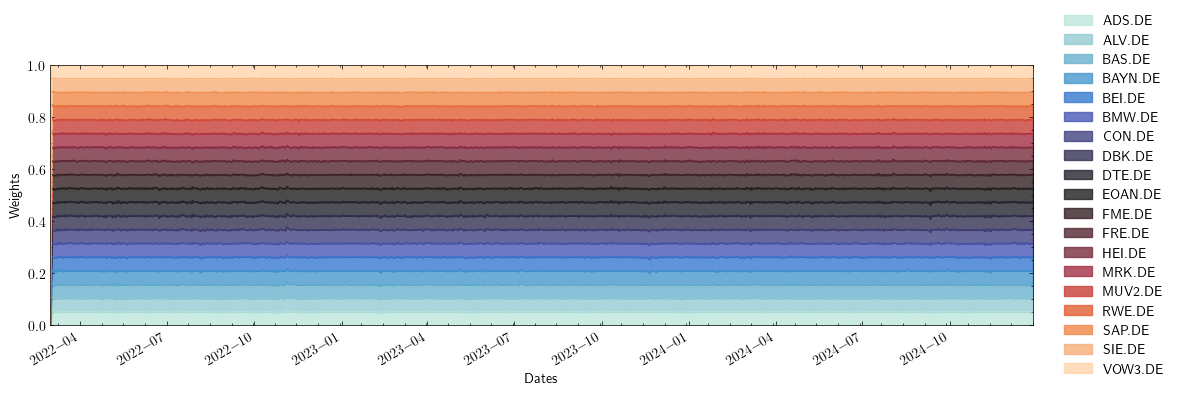

In [184]:
from utils.plotting_helpers import plot_buy_and_hold_weights
plot_buy_and_hold_weights(environment_train_buy_and_hold_sp500,test_data=test_data,ad_cash=False)

## MVO

Initial portfolio value:1000000
Final portfolio value: 1201231.5
Final accumulative portfolio value: 1.2012314796447754
Maximum DrawDown: -0.18824450160745165
Sharpe ratio: 0.5514144317694234


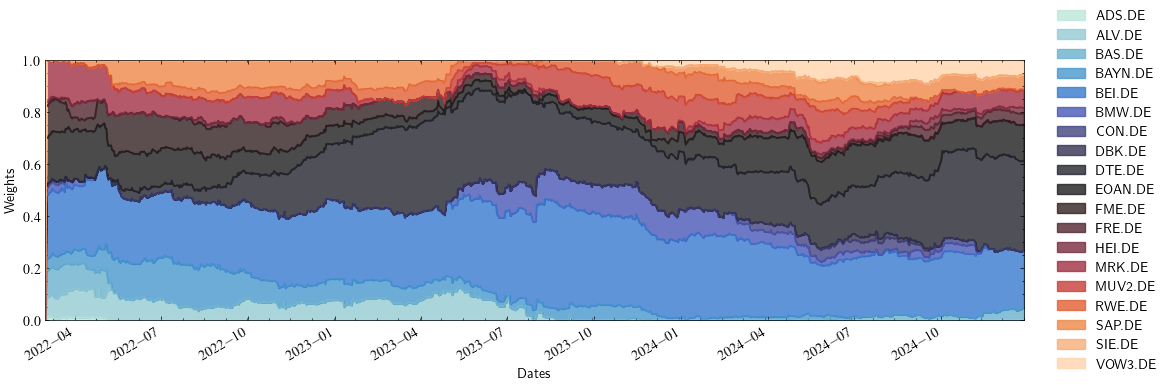

In [27]:
test_covariances = data_split(cleaned_data,TEST_START_DATE,TEST_END_DATE)
min_variacen_portfolio = mvo.mean_variance_optimization(test_covariances,commission_fee=0,window=42)
%matplotlib inline
plot_weights(min_variacen_portfolio[0].weights, min_variacen_portfolio[0].date, min_variacen_portfolio[1],add_cash=False,name='mvo_dow')

## MVO sharpe

Initial portfolio value:1000000
Final portfolio value: 1541533.5
Final accumulative portfolio value: 1.5415334701538086
Maximum DrawDown: -0.18922925000000002
Sharpe ratio: 0.9760738787183925


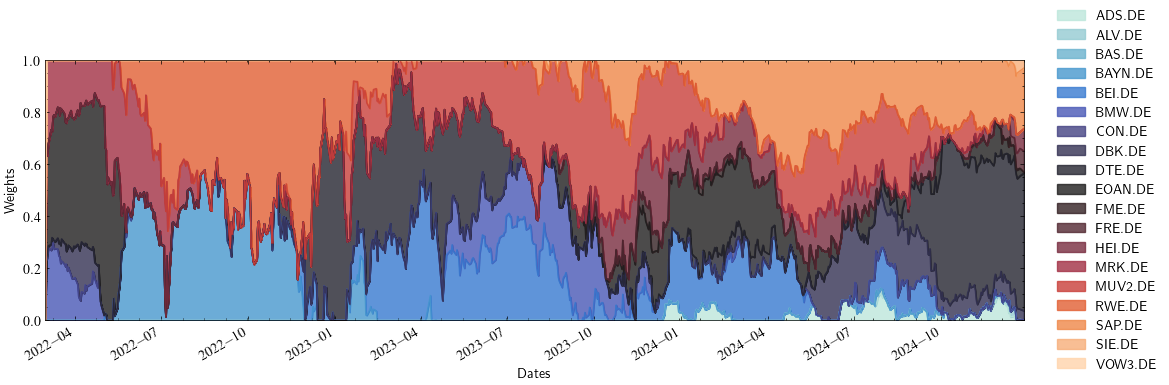

In [28]:
result_sharpe = mvo.mean_variance_optimization(test_covariances,commission_fee=0,objective='sharpe',window=42,risk_free_rate=0.04)
%matplotlib inline
plot_weights(result_sharpe[0].weights, result_sharpe[0].date, result_sharpe[1],add_cash=False,name='mvo_sharpe')

## PPO

In [44]:
%matplotlib inline

import torch
from torch import nn

from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
activ_func = nn.SiLU
use_sharpe_reward = False
optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=use_sharpe_reward, last_weight=False, remove_close=True,flatten_state=False,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30"
#                                 ],
#                         model_name="td3",
#                         args={'gamma': 0.90, 'learning_rate': 1e-4,
#                             "buffer_size": 300_000, "batch_size": 124,
#                             "action_noise": "normal"},
#                         window_size=21,
#                         policy_kwargs=dict(
#                             activation_fn=activ_func,
#                         ),
#                         iterations=1000_000)

test_env = optimizer.create_environment(test_data,
                          features=["close", "log_return", "r_21", "r_42", "r_63","r_252",
                                    "macd", "rsi_30",
                                    ],
                                        window=21)
ppo_test_result = optimizer.load_from_file(
    'RecurrentPPO',test_env, 
    cwd="data/RecurrentPPO_close_log_return_r_21_r_42_r_63_r_252_macd_rsi_30_window_size_21_0.001_recurrent_ppo_dax_dataset_leaky_relu/RecurrentPPO_100000_steps"
    ,deterministic=True)

Successfully load model data/RecurrentPPO_close_log_return_r_21_r_42_r_63_r_252_macd_rsi_30_window_size_21_0.001_recurrent_ppo_dax_dataset_leaky_relu/RecurrentPPO_100000_steps
Initial portfolio value:250000
Final portfolio value: 308361.0
Final accumulative portfolio value: 1.2334439754486084
Maximum DrawDown: -0.2582368089987147
Sharpe ratio: 0.5122769311558628


# TD3

In [25]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(
    transaction_fee=0, comission_fee_model=None,
    tag="flat_state", sharp_reward=False, last_weight=False, remove_close=True,flatten_state=True,
    add_cash=False, env=PortfolioOptimizationEnv
)
# optimizer.train_model(train_data,
#                       validation_data,
#                       features=["close", "log_return", "r_21", "r_42", "r_63",
#                                 "macd", "rsi_30","corr_list"
#                                 ],
#                       model_name="ppo",
#                       args={"n_steps":  1024, "batch_size": 64, 'learning_rate': 1e-4,
#                             'gamma': 0.85, 'gae_lambda': 0.85, 'ent_coef': 0.05},
#                       window_size=5,
#                       iterations=1000_000)

test_env = optimizer.create_environment(test_data,features=[
                                "close", "log_return", "r_21", "r_42", "r_63",
                                "macd", "rsi_30",'corr_list'
                                  ],window=42)
td3_test_result = load_from_file(
    'td3',test_env, 
    cwd="./td3_130000_steps"
    ,deterministic=True)

Successfully load model ./td3_130000_steps
Initial portfolio value:250000
Final portfolio value: 343837.875
Final accumulative portfolio value: 1.3753515481948853
Maximum DrawDown: -0.2273299751090193
Sharpe ratio: 0.7528503048136634


In [45]:
test_env = optimizer.create_environment(test_data,
                          features=["close", "log_return", "r_21", "r_42", "r_63",
                                    "macd", "rsi_30",'corr_list'
                                    ]
                                        ,window=42)
ppo_test_result = load_from_file(
    'ppo',test_env, 
    cwd="data\RecurrentPPO_close_log_return_r_21_r_42_r_63_macd_rsi_30_corr_list_window_size_42_0.001_rppo_dow_leaky_relu\RecurrentPPO_70000_steps"
    ,deterministic=True)
from utils.plotting_helpers import plot_weights
plot_weights(ppo_test_result[0].weights, ppo_test_result[0].date, ppo_test_result[1],add_cash=False,name='td3')

NameError: name 'optimizer' is not defined

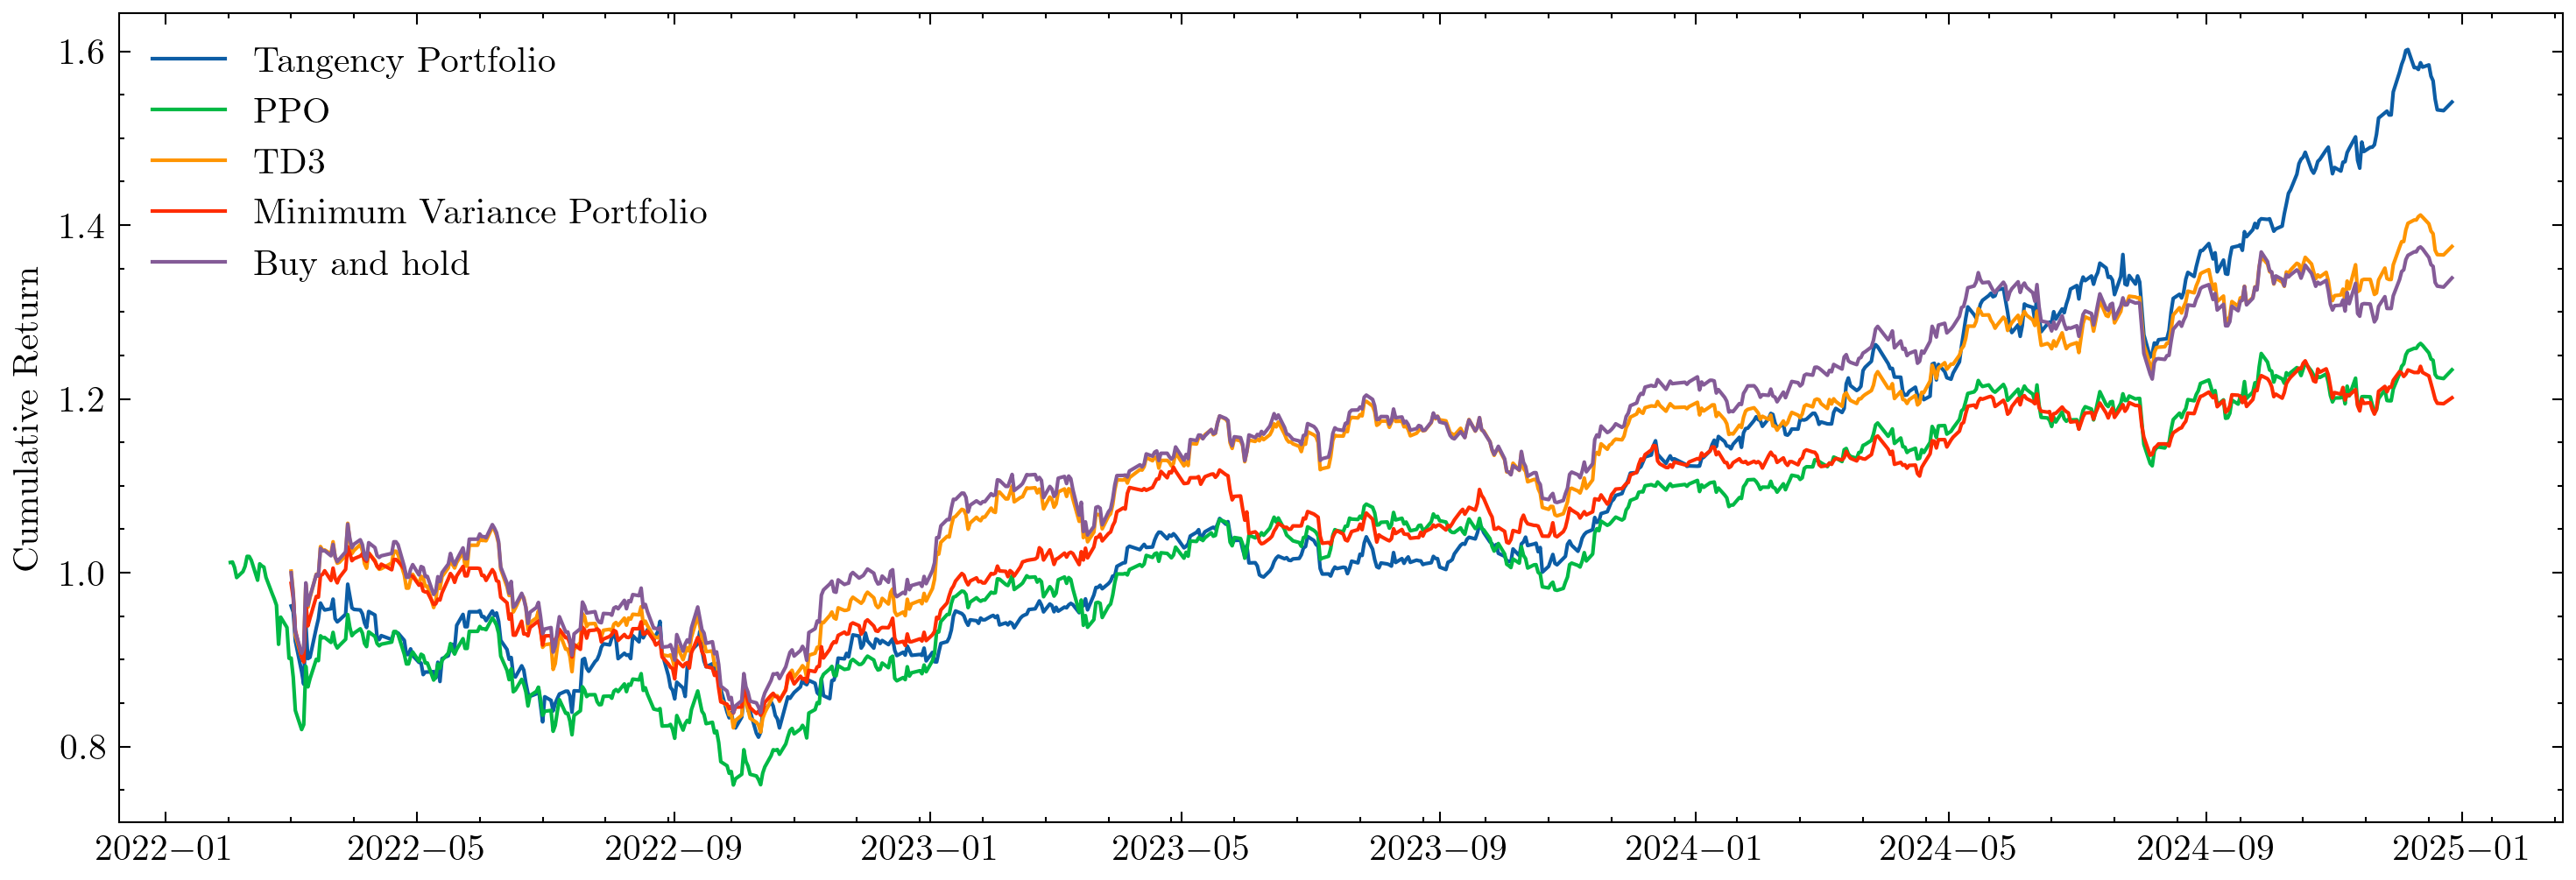

In [46]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_sharpe[0].get('date'),(result_sharpe[0]['account'].pct_change() + 1).cumprod(),label='Tangency Portfolio')
    plt.plot(ppo_test_result[0].get('date'),(ppo_test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(td3_test_result[0].get('date'),(td3_test_result[0]['account'].pct_change() +1).cumprod(),label='TD3')
    plt.plot(min_variacen_portfolio[0].get('date'),(min_variacen_portfolio[0]['account'].pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.savefig('dax_comparison.png', dpi=500)
    plt.show()